In [1]:
import os, sys, requests

sys.path.append(os.path.join(os.pardir,"src"))
import build_dataset as ds
import cg_optimisers as cg_opt
import plotter

Init Plugin
Init Graph Optimizer
Init Kernel


# RSMI optimisation for the dimer model

## Download sample dataset

In [2]:
url = 'https://polybox.ethz.ch/index.php/s/bUp9a5qZWuLGXMb/download'
filename = 'configs_intdimer2d_square_L64_T15.000.npy'
data_dir = os.path.join(os.pardir, 'data')

if os.path.isfile(os.path.join(data_dir, filename)):
    print('Existing dataset found.')
else:
    print('No existing dataset found.')
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        print('Created the data directory.')
    print('Downloading data...')
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(data_dir, filename), 'wb').write(r.content)
    print('Data downloaded into /coarsegrainer/data/.')

Existing dataset found.


## Enter system parameters

In [3]:
data_params = {
    'model': 'intdimer2d',
    'lattice_type': 'square',
    'L': 64,
    'T': 15.000,
    'N_samples': 28800, 
    'dimension': 2,
}

generator=ds.dataset(**data_params)

print(data_params)

Existing data found.
 Loading the data...
Loading complete.
{'model': 'intdimer2d', 'lattice_type': 'square', 'L': 64, 'T': 15.0, 'N_samples': 28800, 'dimension': 2}


## Enter optimisation parameters

In [4]:
CG_params = {'init_temperature': 0.65,
    'min_temperature': 0.1,
    'relaxation_rate': 0.0005, # was 0.0005 for above BKT 0.002 for below BKT
    'num_hiddens': 2,
    'h_embed': True,
    'use_logits': True
}
ll = CG_params['ll'] = (8,8)

opt_params = {
    "batch_size": 750, # was 800 for larger buffers
    "iterations": 200, # was 400 for above BKT, 25 for below BKT
    "shuffle": 100000,
    "learning_rate": 5e-3 # was 4e-3
}

index = (10, 10) # index of the visible patch to be coarse-grained
buffer_size = 4
env_size = 4

V, E = generator.rsmi_data(index, ll, buffer_size=buffer_size, cap=ll[0]+2*(buffer_size+env_size))

Preparing the RSMI dataset...
RSMI dataset prepared.
Metal device set to: AMD Radeon Pro 5500 XT


2021-07-20 21:13:19.783121: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-20 21:13:19.783645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-20 21:13:19.783960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Perform the optimisation and plot results

In [5]:
estimates, _, filters, _ = cg_opt.train_RSMI_optimiser(data_params, CG_params=CG_params, 
                                                       opt_params=opt_params, 
                                                       E=E, V=V, use_GPU=True)

/Users/dorukefegokmen/Documents/Research/RSMI-NE/coarsegrainer/src


  0%|          | 0/7800 [00:00<?, ?it/s]2021-07-20 21:13:21.045498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-20 21:13:21.047904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Gumbel-softmax temperature 0.10, I=0.23: 100%|█████████▉| 7799/7800 [02:22<00:00, 63.00it/s]

Training complete.


RSMI estimate is  0.26120866276866705
{'init_temperature': 0.65, 'min_temperature': 0.1, 'relaxation_rate': 0.0005, 'Nq': None, 'conv_activation': None, 'num_hiddens': 2, 'h_embed': True, 'use_probs': False, 'use_logits': True, 'll': (8, 8)}
{'layers': 3, 'embed_dim': 8, 'hidden_dim': 32, 'activation': 'relu', 'use_dropout': True, 'dropout_rate': 0.25}
{'batch_size': 750, 'iterations': 200, 'shuffle': 100000, 'learning_rate': 0.005}


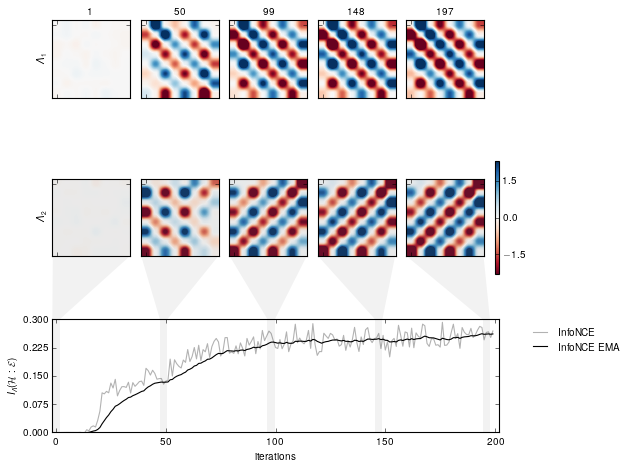

Gumbel-softmax temperature 0.10, I=0.23: 100%|██████████| 7800/7800 [02:40<00:00, 63.00it/s]

In [6]:
print('RSMI estimate is ', cg_opt.RSMI_estimate(estimates, ema_span=20))

plotter.plot_fancy_rsmimax(estimates, filters, opt_params, CG_params, 
                            generator, mi_bound=r'$\rm InfoNCE$', 
                            filter_lim=2.3, EMA_span=20, save=False, 
                            series_skip=opt_params['iterations']//4-1, 
                            interpolation='hanning', cmap='RdBu')

print(CG_params)
print(critic_params)
print(opt_params)